In [ ]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dateutil.parser import parse
from pandas.plotting import autocorrelation_plot
from pandas import Series
from matplotlib import pyplot
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from numpy import hstack
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten,Input

            Date/Time  Theoretical_Power_Curve (KWh)
0 2018-01-01 00:00:00                     416.328908
1 2018-01-01 00:10:00                     519.917511
2 2018-01-01 00:20:00                     390.900016
3 2018-01-01 00:30:00                     516.127569
4 2018-01-01 00:40:00                     491.702972
                     Theoretical_Power_Curve (KWh)
Date/Time                                         
2018-01-01 00:00:00                     416.328908
2018-01-01 00:10:00                     519.917511
2018-01-01 00:20:00                     390.900016
2018-01-01 00:30:00                     516.127569
2018-01-01 00:40:00                     491.702972


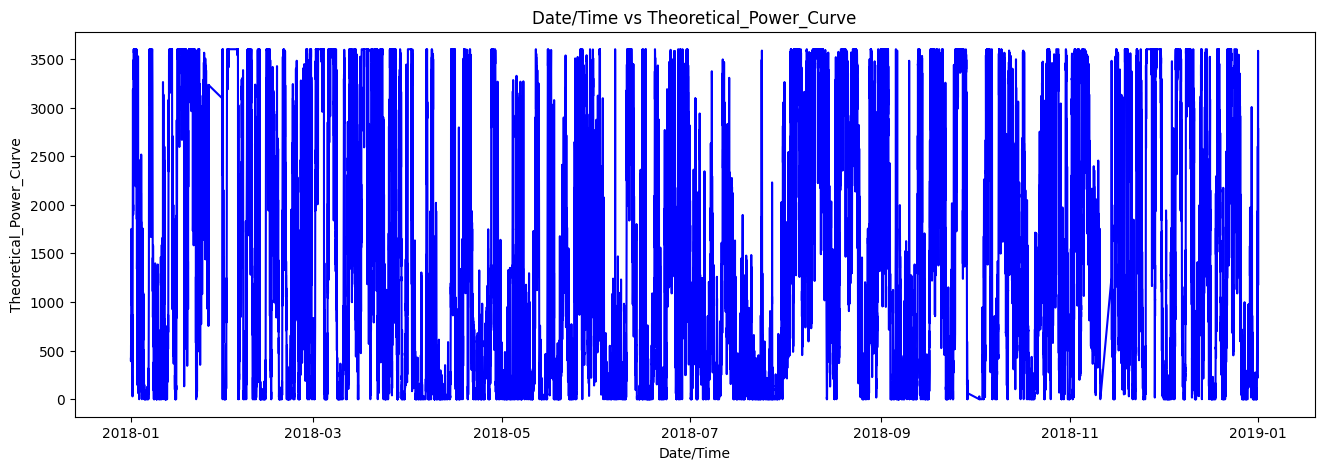

In [ ]:
#1 VISUALIZE THE TIME SERIES
def parser(s):
    return datetime.strptime(s, "%d %m %Y %H:%M")

df = pd.read_csv('https://raw.githubusercontent.com/hemanthhariharan/CS_229_Project/main/T1.csv')
dfIndex = pd.read_csv('https://raw.githubusercontent.com/hemanthhariharan/CS_229_Project/main/T1.csv', parse_dates=[0], index_col=0, date_parser=parser)

# Droping all the irrelavent features that dosent affect the target variable.
dropCols = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Wind Direction (°)' ]
df = df.drop(dropCols, axis=1)
dfIndex = dfIndex.drop(dropCols, axis=1)

#drop null values from data
df = df.dropna()
dfIndex = dfIndex.dropna()

#convert to proper datetime format?
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format = "%d %m %Y %H:%M", errors = "coerce")
print(df.head())
print(dfIndex.head())

# Create figure and plot space
fig, ax = plt.subplots(figsize=(16,5))

# Add x-axis and y-axis
ax.plot(df['Date/Time'],#[200:],
        df['Theoretical_Power_Curve (KWh)'],#[200:],
        color='blue')

# Set title and labels for axes
ax.set(xlabel="Date/Time",
       ylabel="Theoretical_Power_Curve",
       title="Date/Time vs Theoretical_Power_Curve")

plt.show()

In [ ]:
# getting the relevant data
raw_seq = df['Theoretical_Power_Curve (KWh)'].tolist()


In [ ]:

# univariate sequence to samples
def split_sequence(seq, n_stepsI, n_stepsO):
  y =  list()
  X = list()
  for i in range(len(seq)):
    end = i + n_stepsI
    endO = end + n_stepsO

    if endO > len(seq):
      break

    seq_x, seq_y = seq[i:end], seq[end:endO]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)


n_steps_in, n_steps_out = 3, 2
# split  samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)


In [ ]:
#reshaping the data so it mimic image data and the sliding window needed for CNN

print(X.shape)
# reshape from to [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print(X.shape)

(50526, 3)
(50526, 3, 1)


In [ ]:
#split test and train
train_size = int(X.shape[0] * 0.8)
trainX, trainY = X[:train_size], y[:train_size]
testX, testY = X[train_size:], y[train_size:]
print(trainX.shape)
print(trainY.shape)

(40420, 3, 1)
(40420, 2)


In [ ]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
# Dropout(0.2)
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics =['accuracy'])


In [ ]:
# fit model
history = model.fit(trainX, trainY, epochs=1000, verbose=0, validation_data=(testX,testY))

In [ ]:
predictions = model.predict(testX)

316/316 [==============================] - 0s 1ms/step


In [ ]:
from math import sqrt

print("Mean Absolute Percent Error: ", (np.mean(np.abs(((testY+1) - (predictions+1)) / (testY+1)))))
rmse = sqrt(mean_squared_error(testY, predictions))
print('Test RMSE: %.3f' % rmse)

Mean Absolute Percent Error:  3.6753855507929463
Test RMSE: 328.548


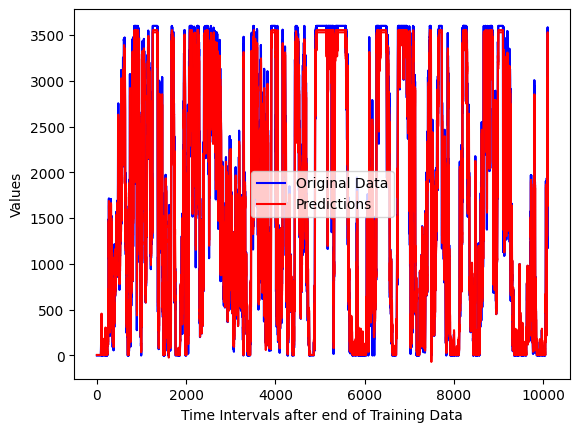

In [ ]:

from collections import OrderedDict
plt.plot(testY, color= 'blue', label='Original Data')

# Plot predictions
plt.plot(predictions, color='red', label='Predictions')

plt.xlabel('Time Intervals after end of Training Data')
plt.ylabel('Values')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

In [ ]:

score = model.evaluate(testX,testY,verbose=0)
print(score)


[107943.4921875, 0.5359192490577698]
